In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option("display.max_column", 10)

c:\Users\akhoc\OneDrive\Documents\march_madness\.venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load the data!

In [2]:
YEAR = 2024
DATA_DIR = f'../../data/{YEAR}/'


In [3]:
tourney_results = pd.read_csv(f'{DATA_DIR}WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv(f'{DATA_DIR}WNCAATourneySeeds.csv')
regular_results = pd.read_csv(
    f'{DATA_DIR}WRegularSeasonDetailedResults.csv')


In [4]:
all(regular_results.columns == tourney_results.columns)

True

# Data preparation!

In [5]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [6]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [7]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,...,11,23,7,6,19
1,2010,11,3104,73,3399,...,7,20,4,2,27
2,2010,11,3110,71,3224,...,8,15,6,0,15
3,2010,11,3111,63,3267,...,15,11,14,5,14
4,2010,11,3119,74,3447,...,12,14,4,2,14


In [8]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,...,WAst,WTO,WStl,WBlk,WPF
0,2010,11,3237,49,3103,...,14,18,7,0,15
1,2010,11,3399,68,3104,...,15,20,5,2,25
2,2010,11,3224,59,3110,...,18,13,6,2,17
3,2010,11,3267,58,3111,...,14,27,5,10,18
4,2010,11,3447,70,3119,...,18,11,5,3,18


In [9]:
regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'
regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [10]:
regular_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,...,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,...,11,23,7,6,19
1,2010,11,3104,73,3399,...,7,20,4,2,27
2,2010,11,3110,71,3224,...,8,15,6,0,15
3,2010,11,3111,63,3267,...,15,11,14,5,14
4,2010,11,3119,74,3447,...,12,14,4,2,14


In [11]:
regular_results_swap.head()

,Season,DayNum,LTeamID,LScore,WTeamID,...,WAst,WTO,WStl,WBlk,WPF
0,2010,11,3237,49,3103,...,14,18,7,0,15
1,2010,11,3399,68,3104,...,15,20,5,2,25
2,2010,11,3224,59,3110,...,18,13,6,2,17
3,2010,11,3267,58,3111,...,14,27,5,10,18
4,2010,11,3447,70,3119,...,18,11,5,3,18


In [12]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [13]:
regular_results.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2010,11,3103,63,3237,...,11,23,7,6,19
1,2010,11,3104,73,3399,...,7,20,4,2,27
2,2010,11,3110,71,3224,...,8,15,6,0,15
3,2010,11,3111,63,3267,...,15,11,14,5,14
4,2010,11,3119,74,3447,...,12,14,4,2,14


In [14]:
regular_results_swap.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2010,11,3237,49,3103,...,14,18,7,0,15
1,2010,11,3399,68,3104,...,15,20,5,2,25
2,2010,11,3224,59,3110,...,18,13,6,2,17
3,2010,11,3267,58,3111,...,14,27,5,10,18
4,2010,11,3447,70,3119,...,18,11,5,3,18


In [15]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

In [16]:
regular_data.head(10)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2010,11,3103,63,3237,...,11,23,7,6,19
1,2010,11,3237,49,3103,...,14,18,7,0,15
2,2010,11,3399,68,3104,...,15,20,5,2,25
3,2010,11,3104,73,3399,...,7,20,4,2,27
4,2010,11,3110,71,3224,...,8,15,6,0,15
5,2010,11,3224,59,3110,...,18,13,6,2,17
6,2010,11,3111,63,3267,...,15,11,14,5,14
7,2010,11,3267,58,3111,...,14,27,5,10,18
8,2010,11,3119,74,3447,...,12,14,4,2,14
9,2010,11,3447,70,3119,...,18,11,5,3,18


In [17]:
tourney_results = pd.read_csv(f'{DATA_DIR}WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv(f'{DATA_DIR}WNCAATourneySeeds.csv')
regular_results = pd.read_csv(
    f'{DATA_DIR}WRegularSeasonDetailedResults.csv')

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [18]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [19]:
regular_data.shape

(152394, 35)

In [20]:
tourney_data.shape

(1654, 35)

In [21]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
1649,2023,147,3268,75,3376,...,12,4,6,12,-11
1650,2023,147,3326,74,3439,...,12,3,4,17,-10
1651,2023,151,3376,73,3234,...,10,8,1,18,-4
1652,2023,151,3439,72,3261,...,7,11,2,15,-7
1653,2023,153,3234,85,3261,...,11,8,3,18,-17


In [22]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2010,11,3103,63,3237,...,23,7,6,19,14
1,2010,11,3104,73,3399,...,20,4,2,27,5
2,2010,11,3110,71,3224,...,15,6,0,15,12
3,2010,11,3111,63,3267,...,11,14,5,14,5
4,2010,11,3119,74,3447,...,14,4,2,14,4


In [23]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2010,138,3124,69,3201,...,18,4,1,18,14
1,2010,138,3173,67,3395,...,8,8,6,22,1
2,2010,138,3181,72,3214,...,16,6,4,20,35
3,2010,138,3199,75,3256,...,16,5,4,24,14
4,2010,138,3207,62,3265,...,10,3,4,12,20


# Feature engineering!

In [24]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [25]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [26]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  ...  \
                       mean       mean      mean       mean       mean  ...   
Season T1_TeamID                                                        ...   
2010   3102       19.142857  53.142857  4.571429  16.071429  12.464286  ...   
       3103       22.233333  55.266667  3.933333  12.466667  14.200000  ...   
       3104       24.724138  62.103448  4.344828  14.724138  14.482759  ...   
       3105       20.370370  50.851852  3.037037   9.888889  13.666667  ...   
       3106       18.448276  53.000000  2.689655   9.586207  15.000000  ...   

                     T2_Ast      T2_TO     T2_Stl    T2_Blk  PointDiff  
                       mean       mean       mean      mean       mean  
Season T1_TeamID                                                        
2010   3102       19.535714  14.392857   9.821429  5.035714 -19.964286  
       3103       11.700000  18.700000   9.233333  3.800000   2.600000  
       3104       12.517241  19.241379   8.758621  3.586207  -2.862069  
       3105       13.481481  20.740741  12.222222  4.407407  -3.962963  
       3106        9.517241  18.310345   8.793103  3.965517  -2.275862  

[5 rows x 19 columns]

In [27]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,...,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,...,mean,mean,mean,mean,mean
0,2010,3102,19.142857,53.142857,4.571429,...,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,...,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,...,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,...,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,...,9.517241,18.310345,8.793103,3.965517,-2.275862


In [28]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,...,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,...,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,...,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,...,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,...,9.517241,18.310345,8.793103,3.965517,-2.275862


In [29]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [30]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,...,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,...,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,...,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,...,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,...,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,...,9.517241,18.310345,8.793103,3.965517,-2.275862


In [31]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,...,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,...,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,...,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,...,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,...,9.517241,18.310345,8.793103,3.965517,-2.275862


In [32]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2010,138,3124,69,3201,...,18,4,1,18,14
1,2010,138,3173,67,3395,...,8,8,6,22,1
2,2010,138,3181,72,3214,...,16,6,4,20,35
3,2010,138,3199,75,3256,...,16,5,4,24,14
4,2010,138,3207,62,3265,...,10,3,4,12,20


In [33]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2010,138,3124,69,3201,55
1,2010,138,3173,67,3395,66
2,2010,138,3181,72,3214,37
3,2010,138,3199,75,3256,61
4,2010,138,3207,62,3265,42


In [34]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [35]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2010,138,3124,69,3201,...,11.848485,19.878788,6.757576,2.606061,12.878788
1,2010,138,3173,67,3395,...,13.466667,20.666667,8.466667,3.500000,12.000000
2,2010,138,3181,72,3214,...,8.733333,22.133333,6.633333,2.266667,7.700000
3,2010,138,3199,75,3256,...,10.741935,17.451613,8.193548,4.225806,9.935484
4,2010,138,3207,62,3265,...,10.727273,15.727273,7.151515,2.303030,10.272727


In [36]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [37]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [38]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean',
       'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d'],
      dtype='object')

In [39]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(7966, 5)

In [40]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [41]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
1649,2023,147,3268,75,3376,...,5.656250,3.906250,30.343750,0.500000,1.0
1650,2023,147,3326,74,3439,...,5.935484,3.129032,15.451613,0.666667,1.0
1651,2023,151,3376,73,3234,...,8.375000,2.906250,16.187500,1.000000,1.0
1652,2023,151,3439,72,3261,...,7.200000,3.600000,26.366667,1.000000,0.5
1653,2023,153,3234,85,3261,...,7.200000,3.600000,26.366667,1.000000,0.5


In [42]:
seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [43]:
seeds.tail()

,Season,Seed,TeamID
1671,2024,Z12b,3435
1672,2024,Z13,3267
1673,2024,Z14,3238
1674,2024,Z15,3263
1675,2024,Z16,3394


In [44]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.head()

,Season,Seed,TeamID,seed
0,1998,W01,3330,1
1,1998,W02,3163,2
2,1998,W03,3112,3
3,1998,W04,3301,4
4,1998,W05,3272,5


In [45]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
seeds_T1

,Season,T1_TeamID,T1_seed
0,1998,3330,1
1,1998,3163,2
2,1998,3112,3
3,1998,3301,4
4,1998,3272,5
...,...,...,...
1671,2024,3435,12
1672,2024,3267,13
1673,2024,3238,14
1674,2024,3263,15


In [46]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [47]:
tourney_data.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed
1649,2023,147,3268,75,3376,...,30.343750,0.500000,1.0,2,1
1650,2023,147,3326,74,3439,...,15.451613,0.666667,1.0,3,1
1651,2023,151,3376,73,3234,...,16.187500,1.000000,1.0,1,2
1652,2023,151,3439,72,3261,...,26.366667,1.000000,0.5,1,3
1653,2023,153,3234,85,3261,...,26.366667,1.000000,0.5,2,3


In [48]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [49]:
tourney_data[tourney_data["Seed_diff"] == 0]

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
62,2010,155,3163,53,3390,...,1.000000,1.000000,1,1,0
125,2011,155,3401,76,3323,...,0.600000,0.500000,2,2,0
186,2012,153,3124,59,3390,...,1.000000,1.000000,1,1,0
187,2012,153,3323,83,3163,...,0.750000,0.750000,1,1,0
188,2012,155,3124,80,3323,...,1.000000,0.750000,1,1,0
249,2013,153,3163,83,3323,...,0.500000,1.000000,1,1,0
314,2014,155,3163,79,3323,...,1.000000,1.000000,1,1,0
375,2015,153,3163,81,3268,...,1.000000,1.000000,1,1,0
376,2015,153,3323,66,3376,...,1.000000,1.000000,1,1,0
377,2015,155,3163,63,3323,...,1.000000,1.000000,1,1,0


# Time to build some models!

In [50]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    1654.000000
mean        0.000000
std        21.434575
min       -89.000000
25%       -14.000000
50%         0.000000
75%        14.000000
max        89.000000
dtype: float64

In [51]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"]

len(features)

43

In [52]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [53]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [54]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [55]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[20:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This 

[50]	train-mae:10.03383+0.04483	test-mae:10.58770+0.10429
[100]	train-mae:9.26952+0.03729	test-mae:10.25858+0.15290
[150]	train-mae:8.83342+0.04493	test-mae:10.24419+0.16444
[180]	train-mae:8.62580+0.05061	test-mae:10.25485+0.16181
Fold repeater 1
[20:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but get

In [56]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([156, 125, 143], [10.2371206, 10.1775268, 10.1644586])

In [57]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
[20:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This 

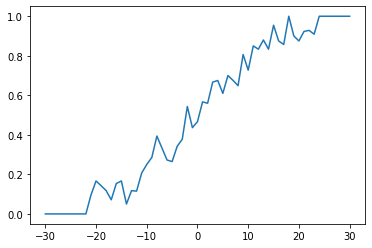

In [58]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [59]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.4430602930641717
logloss of cvsplit 1: 0.44316547384639243
logloss of cvsplit 2: 0.4454840862824084


C:\Users\akhoc\AppData\Local\Temp\ipykernel_22776\1482360335.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()


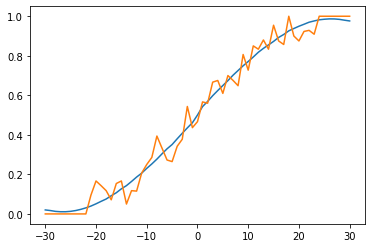

In [60]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [61]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.44434103736820013
adjusted logloss of cvsplit 1: 0.44426185374606825
adjusted logloss of cvsplit 2: 0.44576578237813996


In [62]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    # spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    # spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    # spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    # spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    # spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    # spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    # spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    # spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.44434103736820013
adjusted logloss of cvsplit 1: 0.44426185374606825
adjusted logloss of cvsplit 2: 0.44576578237813996


In [63]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,...,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
978,2012,139,3208,70,3265,...,0.0,1.0,4,13,-9
1488,2021,140,3116,62,3460,...,0.0,1.0,4,13,-9
151,2012,139,3265,76,3208,...,1.0,0.0,13,4,9
661,2021,140,3460,66,3116,...,1.0,0.0,13,4,9


# Submission time!

In [64]:
sub = pd.read_csv(f'{DATA_DIR}WSampleSubmissionStage2.csv')
sub.head()

,ID,Pred
0,2024_3101_3102,0.5
1,2024_3101_3103,0.5
2,2024_3101_3104,0.5
3,2024_3101_3105,0.5
4,2024_3101_3106,0.5


In [65]:
sub["Season"] = YEAR
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2024_3101_3102,0.5,2024,3101,3102
1,2024_3101_3103,0.5,2024,3101,3103
2,2024_3101_3104,0.5,2024,3101,3104
3,2024_3101_3105,0.5,2024,3101,3105
4,2024_3101_3106,0.5,2024,3101,3106


In [66]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,...,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2024_3104_3112,0.5,2024,3104,3112,...,8,11,0.0,0.5,-3
1,2024_3104_3120,0.5,2024,3104,3120,...,8,11,0.0,0.5,-3
2,2024_3112_3120,0.5,2024,3112,3120,...,11,11,0.5,0.5,0
3,2024_3104_3124,0.5,2024,3104,3124,...,8,5,0.0,0.5,3
4,2024_3112_3124,0.5,2024,3112,3124,...,11,5,0.5,0.5,6


In [67]:
len(sub)

2278

In [68]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [69]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
[20:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fold repeater 1
[20:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fold repeater 2
[20:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silen

In [70]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

# sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
# sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
# sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
# sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
# sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
# sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
# sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
# sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0

sub.index += 1


sub[['ID','Pred']].to_csv("ncaa-womens-march-madness-submission.csv", index=False)

In [71]:
sub.count()

ID                      2278
Pred                    2278
Season                  2278
T1_TeamID               2278
T2_TeamID               2278
T1_FGMmean              2278
T1_FGAmean              2278
T1_FGM3mean             2278
T1_FGA3mean             2278
T1_ORmean               2278
T1_Astmean              2278
T1_TOmean               2278
T1_Stlmean              2278
T1_PFmean               2278
T1_opponent_FGMmean     2278
T1_opponent_FGAmean     2278
T1_opponent_FGM3mean    2278
T1_opponent_FGA3mean    2278
T1_opponent_ORmean      2278
T1_opponent_Astmean     2278
T1_opponent_TOmean      2278
T1_opponent_Stlmean     2278
T1_opponent_Blkmean     2278
T1_PointDiffmean        2278
T2_FGMmean              2278
T2_FGAmean              2278
T2_FGM3mean             2278
T2_FGA3mean             2278
T2_ORmean               2278
T2_Astmean              2278
T2_TOmean               2278
T2_Stlmean              2278
T2_PFmean               2278
T2_opponent_FGMmean     2278
T2_opponent_FG

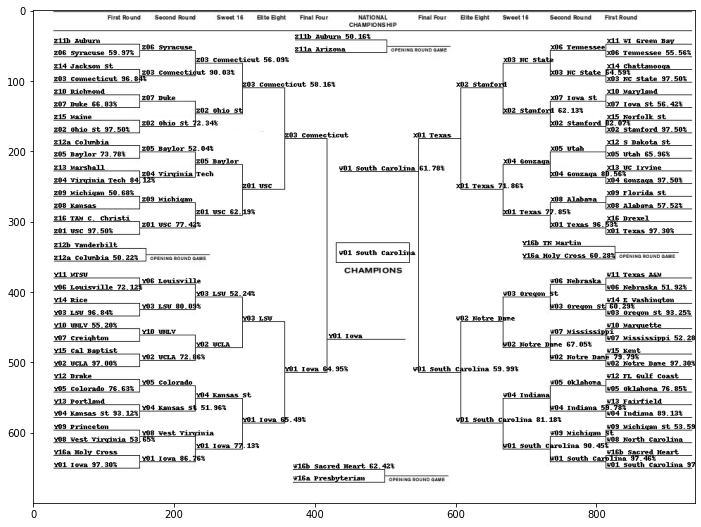

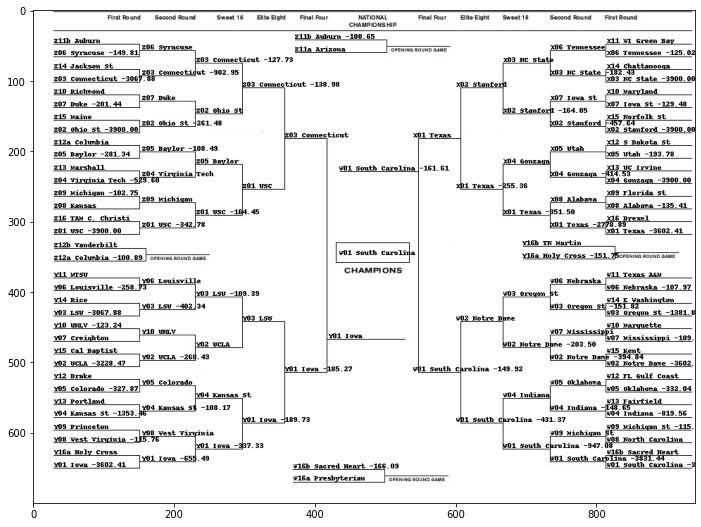

In [72]:
import sys
import os
folder_name = "march_madness"
BASE_DIR = os.path.abspath(".").split(folder_name)[0]+folder_name
#DATA_ROOT = os.path.join(BASE_DIR, "data")
sys.path.insert(0, BASE_DIR)

from generate_bracket.generate_bracket import build_bracket

b = build_bracket(
    teamsPath=f"{DATA_DIR}WTeams.csv",
    seedsPath=f"{DATA_DIR}WNCAATourneySeeds.csv",
    slotsPath=f"{DATA_DIR}WNCAATourneySlots.csv",
    submissionPath="ncaa-womens-march-madness-submission.csv",
    emptyBracketPath="../../empty_bracket/empty.jpg",
    year=YEAR
)

b = build_bracket(
    teamsPath=f"{DATA_DIR}WTeams.csv",
    seedsPath=f"{DATA_DIR}WNCAATourneySeeds.csv",
    slotsPath=f"{DATA_DIR}WNCAATourneySlots.csv",
    submissionPath="ncaa-womens-march-madness-submission.csv",
    emptyBracketPath="../../empty_bracket/empty.jpg",
    year=YEAR,
    bettingOdds=True
)
